#### Importing all the required libraries

In [2]:
%matplotlib inline
from __future__ import print_function
import collections
import math
import numpy as np
import os
import random
import tensorflow as tf
import zipfile
from matplotlib import pylab
from six.moves import range
from six.moves.urllib.request import urlretrieve
from sklearn.manifold import TSNE

print("Imported the libraries.")

Imported the libraries.


#### Downloading the data if required

In [3]:
url = 'http://mattmahoney.net/dc/'

def maybe_download(filename, expected_bytes):
    """Download a file if not present, and make sure it's the right size."""
    if not os.path.exists('./data/'+ filename):
        filename, _ = urlretrieve(url + filename, filename)
    statinfo = os.stat('./data/'+ filename)
    if statinfo.st_size == expected_bytes:
        print('Found and verified %s' % filename)
    else:
        print(statinfo.st_size)
        raise Exception(
          'Failed to verify ' + filename + '. Can you get to it with a browser?')
    return filename

filename = maybe_download('text8.zip', 31344016)
print('Data is downloaded.')

Found and verified text8.zip
Data is downloaded.


#### Reading the data into a string

In [3]:
filename = './data/text8.zip'

def read_data(filename):
    """Extract the first file enclosed in a zip file as a list of words"""
    with zipfile.ZipFile(filename) as f:
        data = tf.compat.as_str(f.read(f.namelist()[0])).split()
    return data
  
words = read_data(filename)
print('Data size %d' % len(words))

Data size 17005207


#### Building the dictionary

In [4]:
vocabulary_size = 50000

def build_dataset(words):
    count = [['UNK', -1]]
    count.extend(collections.Counter(words).most_common(vocabulary_size - 1))
    dictionary = dict()
    for word, _ in count:
        dictionary[word] = len(dictionary)
    data = list()
    unk_count = 0
    for word in words:
        if word in dictionary:
            index = dictionary[word]
        else:
            index = 0  # dictionary['UNK']
            unk_count = unk_count + 1
        data.append(index)
    count[0][1] = unk_count
    reverse_dictionary = dict(zip(dictionary.values(), dictionary.keys())) 
    return data, count, dictionary, reverse_dictionary

data, count, dictionary, reverse_dictionary = build_dataset(words)
print('Most common words (+UNK)', count[:5])
print('Sample data', data[:10])
del words  # Hint to reduce memory.

Most common words (+UNK) [['UNK', 418391], ('the', 1061396), ('of', 593677), ('and', 416629), ('one', 411764)]
Sample data [5237, 3084, 12, 6, 195, 2, 3136, 46, 59, 156]


### Skip-Gram Model

#### Generating training batches

In [5]:
data_index = 0

def generate_batch(batch_size, num_skips, skip_window):
    global data_index
    assert batch_size % num_skips == 0
    assert num_skips <= 2 * skip_window
    batch = np.ndarray(shape=(batch_size), dtype=np.int32)
    labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
    span = 2 * skip_window + 1 # [ skip_window target skip_window ]
    buffer = collections.deque(maxlen=span)
    for _ in range(span):
        buffer.append(data[data_index])
        data_index = (data_index + 1) % len(data)
    for i in range(batch_size // num_skips):
        target = skip_window  # target label at the center of the buffer
        targets_to_avoid = [ skip_window ]
        for j in range(num_skips):
            while target in targets_to_avoid:
                target = random.randint(0, span - 1)
            targets_to_avoid.append(target)
            batch[i * num_skips + j] = buffer[skip_window]
            labels[i * num_skips + j, 0] = buffer[target]
        buffer.append(data[data_index])
        data_index = (data_index + 1) % len(data)
    return batch, labels

print('data:', [reverse_dictionary[di] for di in data[:8]])

for num_skips, skip_window in [(2, 1), (4, 2)]:
    data_index = 0
    batch, labels = generate_batch(batch_size=8, num_skips=num_skips, skip_window=skip_window)
    print('\nwith num_skips = %d and skip_window = %d:' % (num_skips, skip_window))
    print('    batch:', [reverse_dictionary[bi] for bi in batch])
    print('    labels:', [reverse_dictionary[li] for li in labels.reshape(8)])

data: ['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first']

with num_skips = 2 and skip_window = 1:
    batch: ['originated', 'originated', 'as', 'as', 'a', 'a', 'term', 'term']
    labels: ['anarchism', 'as', 'a', 'originated', 'term', 'as', 'of', 'a']

with num_skips = 4 and skip_window = 2:
    batch: ['as', 'as', 'as', 'as', 'a', 'a', 'a', 'a']
    labels: ['a', 'anarchism', 'term', 'originated', 'originated', 'as', 'of', 'term']


#### Skip-Gram model training

In [6]:
batch_size = 128
embedding_size = 128 # Dimension of the embedding vector.
skip_window = 1 # How many words to consider left and right.
num_skips = 2 # How many times to reuse an input to generate a label.
# We pick a random validation set to sample nearest neighbors. here we limit the
# validation samples to the words that have a low numeric ID, which by
# construction are also the most frequent. 
valid_size = 16 # Random set of words to evaluate similarity on.
valid_window = 100 # Only pick dev samples in the head of the distribution.
valid_examples = np.array(random.sample(range(valid_window), valid_size))
num_sampled = 64 # Number of negative examples to sample.

graph = tf.Graph()

with graph.as_default(), tf.device('/cpu:0'):

    # Input data.
    train_dataset = tf.placeholder(tf.int32, shape=[batch_size])
    train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
    valid_dataset = tf.constant(valid_examples, dtype=tf.int32)
  
    # Variables.
    embeddings = tf.Variable(
      tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
    softmax_weights = tf.Variable(
      tf.truncated_normal([vocabulary_size, embedding_size],
                         stddev=1.0 / math.sqrt(embedding_size)))
    softmax_biases = tf.Variable(tf.zeros([vocabulary_size]))
  
    # Model.
    # Look up embeddings for inputs.
    embed = tf.nn.embedding_lookup(embeddings, train_dataset)
    # Compute the softmax loss, using a sample of the negative labels each time.
    loss = tf.reduce_mean(
      tf.nn.sampled_softmax_loss(weights=softmax_weights, biases=softmax_biases, inputs=embed,
                               labels=train_labels, num_sampled=num_sampled, num_classes=vocabulary_size))

    # Optimizer.
    # Note: The optimizer will optimize the softmax_weights AND the embeddings.
    # This is because the embeddings are defined as a variable quantity and the
    # optimizer's `minimize` method will by default modify all variable quantities 
    # that contribute to the tensor it is passed.
    # See docs on `tf.train.Optimizer.minimize()` for more details.
    optimizer = tf.train.AdagradOptimizer(1.0).minimize(loss)

    # Compute the similarity between minibatch examples and all embeddings.
    # We use the cosine distance:
    norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keepdims=True))
    normalized_embeddings = embeddings / norm
    valid_embeddings = tf.nn.embedding_lookup(
      normalized_embeddings, valid_dataset)
    similarity = tf.matmul(valid_embeddings, tf.transpose(normalized_embeddings))

In [7]:
num_steps = 100001

with tf.Session(graph=graph) as session:
    tf.global_variables_initializer().run()
    print('Initialized')
    average_loss = 0
    for step in range(num_steps):
        batch_data, batch_labels = generate_batch(
          batch_size, num_skips, skip_window)
        feed_dict = {train_dataset : batch_data, train_labels : batch_labels}
        _, l = session.run([optimizer, loss], feed_dict=feed_dict)
        average_loss += l
        if step % 2000 == 0:
            if step > 0:
                average_loss = average_loss / 2000
            # The average loss is an estimate of the loss over the last 2000 batches.
            print('Average loss at step %d: %f' % (step, average_loss))
            average_loss = 0
        # note that this is expensive (~20% slowdown if computed every 500 steps)
        if step % 10000 == 0:
            sim = similarity.eval()
            for i in range(valid_size):
                valid_word = reverse_dictionary[valid_examples[i]]
                top_k = 8 # number of nearest neighbors
                nearest = (-sim[i, :]).argsort()[1:top_k+1]
                log = 'Nearest to %s:' % valid_word
                for k in range(top_k):
                    close_word = reverse_dictionary[nearest[k]]
                    log = '%s %s,' % (log, close_word)
                print(log)
    final_embeddings = normalized_embeddings.eval()

Initialized
Average loss at step 0: 8.251881
Nearest to often: galois, title, prerogatives, marlborough, slipped, skit, celebratory, precipitate,
Nearest to however: transmitted, moltke, confederacy, elisabeth, bathe, skinned, fd, suspects,
Nearest to so: vaudeville, bulging, chased, homered, bearings, mouton, biochemistry, yaw,
Nearest to it: menelik, irreversible, ansar, bigg, too, vicinity, eel, rapp,
Nearest to called: meaning, jeanneret, marquette, folsom, embroidered, trolling, dummy, ch,
Nearest to see: microphone, beattie, mathura, drifted, facial, approaches, arthritis, nutrition,
Nearest to who: stepped, diffie, reactors, cordell, however, planters, hydrographic, csce,
Nearest to are: reversing, smyth, buses, head, skeletons, calcite, fruit, crossbow,
Nearest to their: professorship, stole, hobart, jeanne, each, underlying, victoria, tikal,
Nearest to on: chd, emphasized, stereotyping, orbiting, hawley, seneca, klang, boing,
Nearest to one: greece, biologists, cowpox, jon, re

KeyboardInterrupt: 

In [ ]:
num_points = 400

tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000, method='exact')
two_d_embeddings = tsne.fit_transform(final_embeddings[1:num_points+1, :])

In [ ]:
def plot(embeddings, labels):
    assert embeddings.shape[0] >= len(labels), 'More labels than embeddings'
    pylab.figure(figsize=(15,15))  # in inches
    for i, label in enumerate(labels):
        x, y = embeddings[i,:]
        pylab.scatter(x, y)
        pylab.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points',
                   ha='right', va='bottom')
    pylab.show()

words = [reverse_dictionary[i] for i in range(1, num_points+1)]
plot(two_d_embeddings, words)

### CBOW Model


#### Generating training batches

In [8]:
data_index = 0

def generate_batch(batch_size, window):
    global data_index
    batch = np.ndarray(shape=(batch_size, window*2), dtype=np.int32)
    labels = np.ndarray(shape=(batch_size), dtype=np.int32)
    context = np.ndarray(shape=(window*2), dtype=np.int32)
    for n in range(batch_size):
        labels[n] = data[data_index]
        span  = [j for j in range(data_index - window, data_index + window + 1)]
        cnt = 0
        for i in span:
            if i < 0 or i >= len(data):
                context[cnt] = 0 #0 is the id for UNK
            elif i == data_index:
                continue
            else:
                context[cnt] = data[i]
            cnt += 1
        batch[n] = context
        data_index = (data_index + 1)%len(data)
    return batch, labels

for window in (1,2):
    data_index = window
    batch, labels = generate_batch(8, window)
    print('\nWindow = %d:' % (window))
    print('    batch:', [[reverse_dictionary[i] for i in bi] for bi in batch])
    print('    labels:', [reverse_dictionary[li] for li in labels])


Window = 1:
    batch: [['anarchism', 'as'], ['originated', 'a'], ['as', 'term'], ['a', 'of'], ['term', 'abuse'], ['of', 'first'], ['abuse', 'used'], ['first', 'against']]
    labels: ['originated', 'as', 'a', 'term', 'of', 'abuse', 'first', 'used']

Window = 2:
    batch: [['anarchism', 'originated', 'a', 'term'], ['originated', 'as', 'term', 'of'], ['as', 'a', 'of', 'abuse'], ['a', 'term', 'abuse', 'first'], ['term', 'of', 'first', 'used'], ['of', 'abuse', 'used', 'against'], ['abuse', 'first', 'against', 'early'], ['first', 'used', 'early', 'working']]
    labels: ['as', 'a', 'term', 'of', 'abuse', 'first', 'used', 'against']


#### CBOW model training

In [17]:
batch_size = 64
embedding_size = 128 # Dimension of the embedding vector.
window = 1 # Context window size

valid_size = 16 # Random set of words to evaluate similarity on.
valid_window = 100 # Only pick dev samples in the head of the distribution.
valid_examples = np.array(random.sample(range(valid_window), valid_size))
num_sampled = 64 # Number of negative examples to sample.

graph = tf.Graph()

with graph.as_default(), tf.device('/cpu:0'):

    # Input data.
    train_dataset = tf.placeholder(tf.int32, shape=[batch_size,2*window])
    train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
    valid_dataset = tf.constant(valid_examples, dtype=tf.int32)

    # Variables.
    # embedding, vector for each word in the vocabulary
    embeddings = tf.Variable(tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
    softmax_weights = tf.Variable(tf.truncated_normal([vocabulary_size, embedding_size],
                     stddev=1.0 / math.sqrt(embedding_size)))
    softmax_biases = tf.Variable(tf.zeros([vocabulary_size]))
    
    
    # Model.
    embeds = None
    for i in range(2*skip_window):
        embedding_i = tf.nn.embedding_lookup(embeddings, train_dataset[:,i])
        print('embedding %d shape: %s'%(i,embedding_i.get_shape().as_list()))
        emb_x,emb_y = embedding_i.get_shape().as_list()
        if embeds is None:
            embeds = tf.reshape(embedding_i,[emb_x,emb_y,1])
        else:
            embeds = tf.concat([embeds,tf.reshape(embedding_i,[emb_x,emb_y,1])], 2)

    assert embeds.get_shape().as_list()[2]==2*skip_window
    print("Concat embedding size: %s"%embeds.get_shape().as_list())
    avg_embed =  tf.reduce_mean(embeds,2,keepdims=False)
    print("Avg embedding size: %s"%avg_embed.get_shape().as_list())
    
    
    loss = tf.reduce_mean(tf.nn.sampled_softmax_loss(
            weights=softmax_weights,
            biases=softmax_biases,
            inputs=avg_embed,
            labels=train_labels,
            num_sampled=num_sampled,
            num_classes=vocabulary_size))
    
    optimizer = tf.train.AdagradOptimizer(1.0).minimize(loss)

    # We use the cosine distance:
    norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))
    normalized_embeddings = embeddings / norm
    valid_embeddings = tf.nn.embedding_lookup(normalized_embeddings, valid_dataset)
    similarity = tf.matmul(valid_embeddings, tf.transpose(normalized_embeddings))

embedding 0 shape: [64, 128]
embedding 1 shape: [64, 128]
Concat embedding size: [64, 128, 2]
Avg embedding size: [64, 128]
Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [19]:
num_steps = 100001

with tf.Session(graph=graph) as session:
    tf.global_variables_initializer().run()
    print('Initialized')
    average_loss = 0
    for step in range(num_steps):
        batch_data, batch_labels = generate_batch(
          batch_size, window)
        feed_dict = {train_dataset : batch_data, train_labels : batch_labels.reshape([-1, 1])}
        _, l = session.run([optimizer, loss], feed_dict=feed_dict)
        average_loss += l
        if step % 2000 == 0:
            if step > 0:
                average_loss = average_loss / 2000
            # The average loss is an estimate of the loss over the last 2000 batches.
            print('Average loss at step %d: %f' % (step, average_loss))
            average_loss = 0
        # note that this is expensive (~20% slowdown if computed every 500 steps)
        if step % 10000 == 0:
            sim = similarity.eval()
            for i in range(valid_size):
                valid_word = reverse_dictionary[valid_examples[i]]
                top_k = 8 # number of nearest neighbors
                nearest = (-sim[i, :]).argsort()[1:top_k+1]
                log = 'Nearest to %s:' % valid_word
                for k in range(top_k):
                    close_word = reverse_dictionary[nearest[k]]
                    log = '%s %s,' % (log, close_word)
                print(log)
    final_embeddings = normalized_embeddings.eval()

Initialized
Average loss at step 0: 7.013847
Nearest to nine: hic, judeo, supine, wishes, eee, garrisoned, inhabit, gasses,
Nearest to who: pentagram, twig, debrecen, panspermia, lillian, gath, proposed, killing,
Nearest to see: manuel, incestuous, intersection, rosen, chimpanzees, jezreel, patriot, diacritical,
Nearest to but: bipartisan, unlock, feuds, upanishads, testable, yu, bodyline, gestures,
Nearest to or: kino, wreck, mech, vapor, regicide, richest, jeremy, decipher,
Nearest to four: cmb, avicenna, wreath, kicking, neg, gleaned, ichi, mimosa,
Nearest to world: decreases, girdle, shareholders, hashanah, entourage, ebbets, algirdas, axel,
Nearest to had: raiders, kava, descendants, kouchner, maths, splitting, practices, paco,
Nearest to so: navin, vit, everson, gibb, railtrack, levelling, pregnancy, patricio,
Nearest to were: conclude, baikal, chaco, sal, behaviorism, szl, postfix, lace,
Nearest to of: hutu, hordes, robbers, languages, pople, fingered, subnet, untimely,
Nearest 

Nearest to there: they, it, he, hydro, typically, contend, now, she,
Nearest to he: she, it, they, eventually, ruth, there, who, mantle,
Nearest to some: many, several, these, this, any, wadsworth, unicorn, homogenized,
Average loss at step 52000: 2.802488
Average loss at step 54000: 2.872397
Average loss at step 56000: 2.862037
Average loss at step 58000: 2.899762
Average loss at step 60000: 2.788792
Nearest to nine: eight, six, seven, four, five, zero, three, one,
Nearest to who: lumumba, he, raccoons, cassidy, which, aubrey, yakovlev, inverses,
Nearest to see: external, but, include, calming, adhering, pickling, antoni, ruse,
Nearest to but: however, although, though, and, see, attila, which, superorder,
Nearest to or: and, upsilon, cashier, than, huguenots, indebted, han, encampments,
Nearest to four: six, five, eight, seven, three, nine, two, zero,
Nearest to world: u, rabbinic, magisterial, barreled, vietnam, workhorse, transverse, nurtured,
Nearest to had: has, have, was, were, 

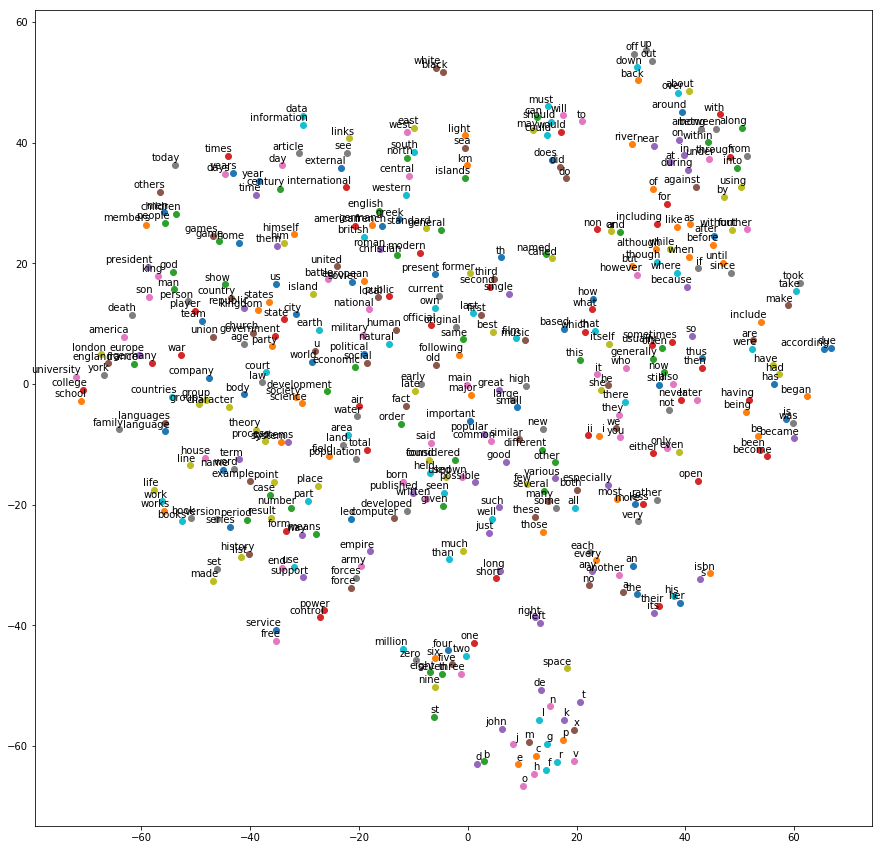

In [20]:
num_points = 400

tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000, method='exact')
two_d_embeddings = tsne.fit_transform(final_embeddings[1:num_points+1, :])

def plot(embeddings, labels):
    assert embeddings.shape[0] >= len(labels), 'More labels than embeddings'
    pylab.figure(figsize=(15,15))  # in inches
    for i, label in enumerate(labels):
        x, y = embeddings[i,:]
        pylab.scatter(x, y)
        pylab.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points',
                   ha='right', va='bottom')
    pylab.show()

words = [reverse_dictionary[i] for i in range(1, num_points+1)]
plot(two_d_embeddings, words)